In [1]:
'''
Brendan Heberlain, Olee Lam, Phuong Dao
---------------------

Required packages:
arosics
cartopy
gdal
geopandas
matplotlib
numpy
pandas
pyfftw <0.13.0
pykrige
pyproj >2.2.0
scikit-image >=0.16.0
shapely
envi (read envi images)

'''


'\nBrendan Heberlain, Olee Lam, Phuong Dao\n---------------------\n\nRequired packages:\narosics\ncartopy\ngdal\ngeopandas\nmatplotlib\nnumpy\npandas\npyfftw <0.13.0\npykrige\npyproj >2.2.0\nscikit-image >=0.16.0\nshapely\nenvi (read envi images)\n\n'

In [2]:
# Import required packages
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from geoarray import GeoArray
from arosics import COREG, COREG_LOCAL
from osgeo import gdal

# Path Setup

In [25]:
# EnSpec drive
enspec = Path('Z:/townsenduser-rw/projects/WisAsp/z_codes/coreg')
assert enspec.exists()

In [26]:
import sys
sys.path.append(str(enspec/'envi'))
#from hypro.lib.io.ENVI import ENVI
#from hypro.display.image import linear_percent_stretch

In [27]:
from envi import ENVI, linear_percent_stretch

## Load the regerence image

In [28]:
# basemap_file = wd/'basemap/UW-Arboreturm_WROC2020_Intensity32616.tif'
basemap_file = enspec/'Z_Input_Data/AARS_WisAsp_06022021_RGB'
reference_geoarray = GeoArray(str(basemap_file))

Note: array has been downsampled to 541 x 1000 for faster visualization.


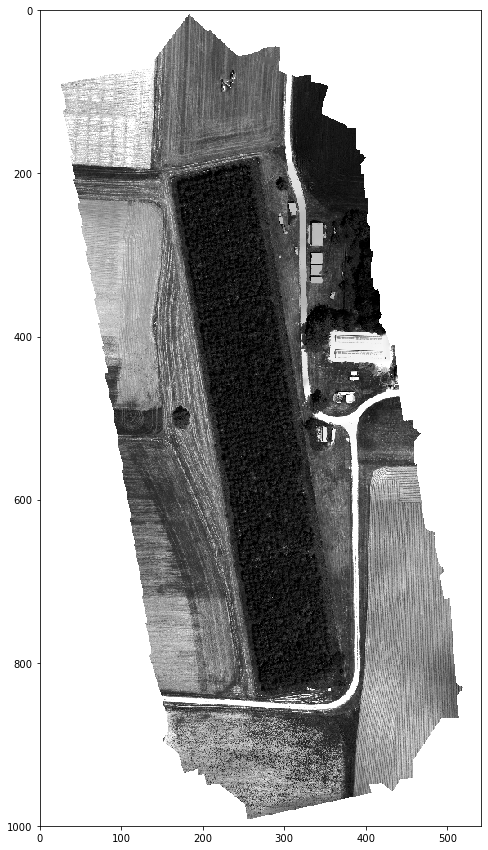

In [29]:
reference_geoarray.show(figsize = (10,15))

## Load target images

In [8]:
# Define filepaths to input images (we will use georectified radiance)
target_file = enspec/('Z_Input_Data/GENO-1_20210602_02_Refl_brdf')
print(target_file)

# Load image data
target = ENVI.from_file(target_file)

Z:\townsenduser-rw\projects\WisAsp\z_codes\coreg\Z_Input_Data\GENO-1_20210602_02_Refl_brdf


## Coregistration to a Basemap Image

In [9]:
# Select bands to use from reflectance image
band = 150

# Subset each image by selecting a single band
target_subset = target.data[band]

# The geotransform array for each image grid is known from the ENVI header
target.gt

(311081.2, 0.40000000002, 0, 4798837.2, 0, -0.40000000002)

In [10]:
# Load band into GeoArray object
target_geoarray = GeoArray(target_subset, geotransform=target.gt, projection=target.crs.ExportToWkt())

In [11]:
# The projections aren't matching due to lossiness of the PROJ4 representation. We will force them to be equal.
# NOTE: Try doing the coregistration without running this first...
reference_geoarray.projection = target_geoarray.projection

In [12]:
# Setup parameters for tiepoint detection and affine transformation factor calculation
coreg_kwargs = {
    'grid_res': 40, # Tie point spacing in x-direction, in terms of target image pixels
    'window_size': (164, 164), # Size of matching window
    'nodata': (0.0, -9999.0), # No-data values for reference & target images
    'max_iter': 8,
    'r_b4match': 1, # Reference band for matching
    's_b4match': 1, # Target band for matching
    'CPUs': 1,      # Windows can't run with multiple CPUs
    'max_shift': 150,
    'min_reliability': 20
}

# Apply local image coregistration
CRL = COREG_LOCAL(reference_geoarray, target_geoarray, **coreg_kwargs)

# Inspect the result
CRL.correct_shifts()

Calculating footprint polygon and actual data corner coordinates for reference image...


Polygonize progress     |==================================================| 100.0% Complete  => 0:00:00


Bounding box of calculated footprint for reference image:
	(311091.7247908, 4798326.6019229, 311339.1610806, 4798822.4071685)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...


Polygonize progress     |==================================================| 100.0% Complete  => 0:00:00


Bounding box of calculated footprint for image to be shifted:
	(311081.2, 4798334.799999975, 311351.2000000135, 4798837.2)
Matching window position (X,Y): 311215.8329039201/4798575.036058343
Initializing tie points grid...
Equalizing pixel grids and projections of reference and target image...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
	progress: |--------------------------------------------------| 0.4% Complete  => 0:00:00

Calculating tie point grid (281 points) on 1 CPU core...


	progress: |==================================================| 100.0% Complete  => 0:01:48
E:\sandbox\conda\envs\pdao\lib\site-packages\arosics\DeShifter.py:291: UserWarning: 
The coordinate grid of IN_MEM cannot be aligned to the desired grid because their pixel sizes are not exact multiples of each other (input [X/Y]: 0.40000000002/0.40000000002; desired [X/Y]: 0.0466333000222221/0.04663330037146807). Therefore the original grid is chosen for the resampled output image. If you don´t like that you can use the 'out_gsd' or 'match_gsd' parameters to set an appropriate output pixel size or to allow changing the pixel size.

  warnings.warn("\nThe coordinate grid of %s cannot be aligned to the desired grid because their pixel "
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |================----------------------------------| 32.0% Complete  => 0:00:00

Found 216 matches.
Performing validity checks...
48 tie points flagged by level 1 filtering (reliability).
71 tie points flagged by level 2 filtering (SSIM).
11 tie points flagged by level 3 filtering (RANSAC)
116 valid tie points remain after filtering.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00


OrderedDict([('band', None),
             ('is shifted', True),
             ('is resampled', True),
             ('updated map info',
              ['UTM',
               1.0,
               1.0,
               311081.2,
               4798837.2,
               0.40000000002328306,
               0.40000000037252903,
               16,
               'North',
               'WGS-84']),
             ('updated geotransform',
              (311081.2,
               0.40000000002328306,
               0.0,
               4798837.2,
               0.0,
               -0.40000000037252903)),
             ('updated projection',
              'PROJCS["wgs_1984_utm_zone_16n",GEOGCS["gcs_gcs_gcs_wgs_1984",DATUM["WGS_1984",SPHEROID["wgs_1984",6378137,298.257223563]],PRIMEM["greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],PARAMETER["central_meridian",-87],PARAMETER["scale_factor",0.9996],PARAMETER["

In [13]:
with np.errstate(over='ignore', divide='ignore', invalid='ignore'): # Ignore AROSICS complaining
    result = CRL.correct_shifts()

E:\sandbox\conda\envs\pdao\lib\site-packages\arosics\DeShifter.py:291: UserWarning: 
The coordinate grid of IN_MEM cannot be aligned to the desired grid because their pixel sizes are not exact multiples of each other (input [X/Y]: 0.40000000002/0.40000000002; desired [X/Y]: 0.0466333000222221/0.04663330037146807). Therefore the original grid is chosen for the resampled output image. If you don´t like that you can use the 'out_gsd' or 'match_gsd' parameters to set an appropriate output pixel size or to allow changing the pixel size.

  warnings.warn("\nThe coordinate grid of %s cannot be aligned to the desired grid because their pixel "
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |======================----------------------------| 43.1% Complete  => 0:00:00

Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00


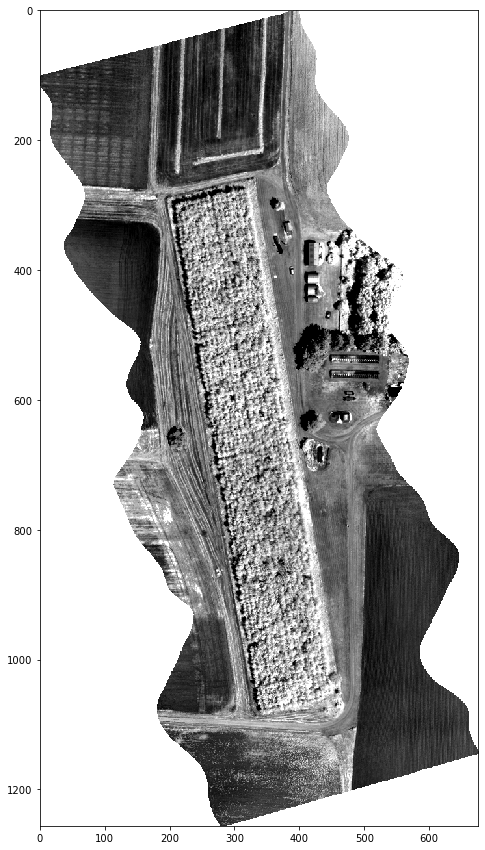

In [14]:
# Show the corrected target image geoarray
result['GeoArray_shifted'].show(figsize = (10,15))

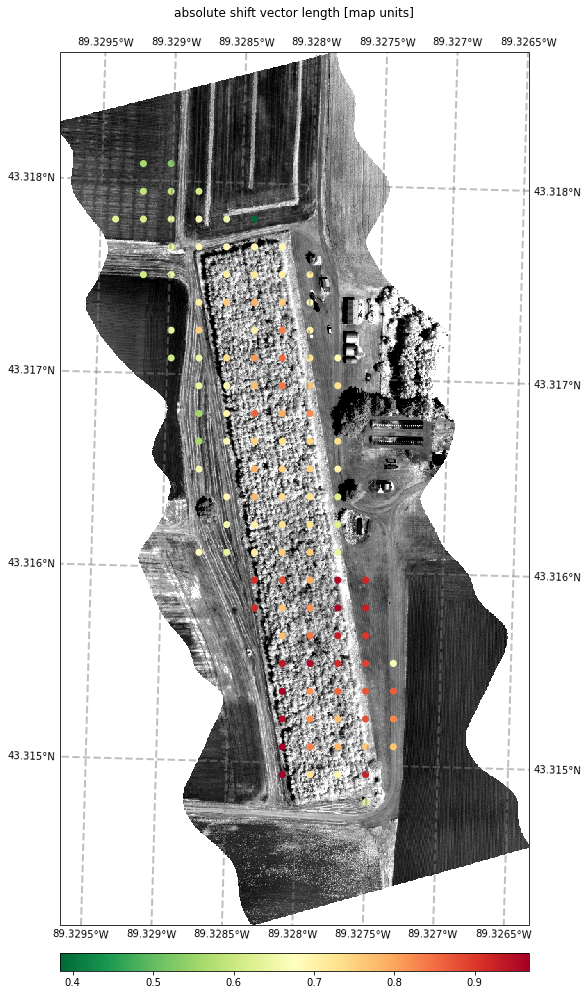

In [15]:
# Show tie points on top of the target image
CRL.view_CoRegPoints()

In [16]:
# Show the points table of the calculated tie point grid
# Notes: Point records where no valid match has been found are filled with -9999.0
# False-positive "labeled as False" points are not used to compute transformation factors
CRL.CoRegPoints_table

,geometry,POINT_ID,X_IM,Y_IM,X_MAP,Y_MAP,REF_BADDATA,TGT_BADDATA,X_WIN_SIZE,Y_WIN_SIZE,...,ANGLE,SSIM_BEFORE,SSIM_AFTER,SSIM_IMPROVED,RELIABILITY,LAST_ERR,L1_OUTLIER,L2_OUTLIER,L3_OUTLIER,OUTLIER
0,POINT (311161.200 4798805.200),41,200,80,311161.2,4798805.2,False,False,-9999.0,-9999.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,One of the input images does not have sufficie...,-9999,-9999,-9999,-9999
1,POINT (311177.200 4798805.200),42,240,80,311177.2,4798805.2,False,False,34.0,32.0,...,299.200405,0.125417,0.184066,True,0.000000,-9999,True,False,False,True
2,POINT (311145.200 4798789.200),58,160,120,311145.2,4798789.2,False,False,-9999.0,-9999.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,One of the input images does not have sufficie...,-9999,-9999,-9999,-9999
3,POINT (311161.200 4798789.200),59,200,120,311161.2,4798789.2,False,False,44.0,44.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,No match found in the given window.,-9999,-9999,-9999,-9999
4,POINT (311177.200 4798789.200),60,240,120,311177.2,4798789.2,False,False,74.0,74.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,No match found in the given window.,-9999,-9999,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,POINT (311225.200 4798357.200),549,360,1200,311225.2,4798357.2,False,False,50.0,48.0,...,13.509249,-0.062440,-0.407665,False,52.872539,-9999,False,True,False,True
277,POINT (311241.200 4798357.200),550,400,1200,311241.2,4798357.2,False,False,32.0,30.0,...,8.983465,-0.107679,-0.687243,False,26.332471,-9999,False,True,False,True
278,POINT (311257.200 4798357.200),551,440,1200,311257.2,4798357.2,False,False,-9999.0,-9999.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,One of the input images does not have sufficie...,-9999,-9999,-9999,-9999
279,POINT (311273.200 4798357.200),552,480,1200,311273.2,4798357.2,False,False,-9999.0,-9999.0,...,-9999.000000,-9999.000000,-9999.000000,-9999,-9999.000000,One of the input images does not have sufficie...,-9999,-9999,-9999,-9999


In [17]:
# Export tie point grid to an ESRI point shapefile
tiepoint_file = enspec/('Z_Output_Data/GENO-1_20210602_02_Refl_brdf_tiepoint')

CRL.tiepoint_grid.to_PointShapefile(path_out = tiepoint_file)

Writing Z:\townsenduser-rw\projects\WisAsp\z_codes\coreg\Z_Output_Data\GENO-1_20210602_02_Refl_brdf_tiepoint ...


E:\sandbox\conda\envs\pdao\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
E:\sandbox\conda\envs\pdao\lib\site-packages\arosics\Tie_Point_Grid.py:888: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  GDF2pass.to_file(path_out)


# Applying Calculated Shifts
Now we will use the calculated shifts to warp the full-band dataset.

In [18]:
from arosics import DESHIFTER

# GeoArray is expecting the data as BIP interleave, i.e. (rows, columns, bands)
target_all_bands = np.moveaxis(target.data, 0, -1)

# Convert the image data to a geoarray
# NOTE: in this case the array is a numpy memory-mapped array, so it should not be loaded into memory
target_geoarray_all_bands = GeoArray(target_all_bands,
                                   geotransform=target_geoarray.geotransform,
                                   projection=target_geoarray.projection)


# Apply previously-calculated shifts to the full-band image
deshifter = DESHIFTER(target_geoarray_all_bands, CRL.coreg_info)

# Warp the full-band image "with the cubic convolution resampling"
target_shifted_all_bands = deshifter.correct_shifts()

# Get shifted GeoArray
target_geoarray_shifted_all_bands = target_shifted_all_bands['GeoArray_shifted']

# Set file path to shifted image
target_file_shifted_all_bands = enspec/('Z_Output_Data/GENO-1_20210602_02_Refl_brdf_coreg')

# Save the shifted image into ENVI *.hdr format with metada
target_geoarray_shifted_all_bands.save(str(target_file_shifted_all_bands),
                                       fmt='ENVI', creationOptions = ["WRITE_METADATA=YES"])

Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Automatically detected nodata value for GeoArray 'IN_MEM': -9999.0
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:03:30
Warping progress     |==================================================| 100.0% Complete  => 0:00:48


Writing GeoArray of size (1256, 675, 474) to Z:\townsenduser-rw\projects\WisAsp\z_codes\coreg\Z_Output_Data\GENO-1_20210602_02_Refl_brdf_coreg.


In [23]:
# visualize tie point grid with shifts present AFTER shift correction
#CRL_after_corr = COREG_LOCAL(reference_geoarray, target_geoarray_shifted_all_bands, **coreg_kwargs)

In [24]:
# Show tie points
#CRL_after_corr.view_CoRegPoints()